# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List
import math

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    data = pd.read_csv(path_to_csv)
    shuffled_data = data.sample(frac=1)
    y = shuffled_data["label"].apply(lambda x: 1 if x == 'M' else 0)
    X = shuffled_data.drop(columns=["label"])
    return np.array(X), np.array(y)

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    data = pd.read_csv(path_to_csv)
    shuffled_data = data.sample(frac=1)
    y = shuffled_data["label"].apply(lambda x: x)
    X = shuffled_data.drop(columns=["label"])
    return np.array(X), np.array(y)

In [3]:
read_cancer_dataset("cancer.csv")

(array([[1.546e+01, 2.395e+01, 1.038e+02, ..., 2.163e-01, 3.013e-01,
         1.067e-01],
        [1.730e+01, 1.708e+01, 1.130e+02, ..., 1.857e-01, 3.138e-01,
         8.113e-02],
        [1.245e+01, 1.570e+01, 8.257e+01, ..., 1.741e-01, 3.985e-01,
         1.244e-01],
        ...,
        [2.018e+01, 1.954e+01, 1.338e+02, ..., 2.173e-01, 3.032e-01,
         8.075e-02],
        [1.246e+01, 2.404e+01, 8.397e+01, ..., 2.210e-01, 4.366e-01,
         2.075e-01],
        [1.129e+01, 1.304e+01, 7.223e+01, ..., 8.750e-02, 2.733e-01,
         8.022e-02]]),
 array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
 

In [4]:
read_spam_dataset("spam.csv")

(array([[  0.   ,   0.   ,   0.   , ...,   3.657,  35.   , 534.   ],
        [  0.   ,   0.   ,   0.85 , ...,   1.085,   3.   ,  89.   ],
        [  0.   ,   0.   ,   0.   , ...,   1.529,   4.   ,  26.   ],
        ...,
        [  0.   ,   0.   ,   0.   , ...,   1.   ,   1.   ,  14.   ],
        [  0.   ,   0.   ,   0.   , ...,   1.461,   6.   ,  19.   ],
        [  0.   ,   0.   ,   0.   , ...,   2.96 ,  19.   , 222.   ]]),
 array([0, 0, 0, ..., 0, 0, 1]))

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [5]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    size_train = math.floor(len(X) * ratio)
    return X[:size_train], y[:size_train], X[size_train:], y[size_train:]

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [6]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:

    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
        
    recall = []
    precision = []
    classes = np.unique(np.concatenate([y_true, y_pred]))
    accuracy = 0
    count = 0
    for i in range(0, len(y_true)):
        if y_true[i] == y_pred[i]:
            count += 1
    accuracy = count / len(y_true)
    for cur in classes:
        tp = 0
        fp = 0
        fn = 0
        for j in range(0, len(y_pred)):
            if y_true[j] == cur and y_pred[j] == cur:
                tp += 1
            if y_true[j] != cur and y_pred[j] == cur:   
                fp += 1
            if y_true[j] == cur and y_pred[j] != cur:
                fn += 1
        precision.append(tp / (tp + fp) if tp + fp != 0 else 0)
        recall.append(tp / (tp + fn) if tp + fn != 0 else 0)
        
    return np.array(precision), np.array(recall), accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [7]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [8]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [9]:
class Point:
    def __init__(self, index: int, datum: np.array):
        self.index = index
        self.datum = datum


class Node:
    def __init__(self, left_son, right_son, data, is_leaf):
        self.left_son = left_son
        self.right_son = right_son
        self.data = data
        self.is_leaf = is_leaf


class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области,
            в которых не меньше leaf_size точек).

        Returns
        -------

        """
        self.leaf_size = leaf_size
        self.dimension = len(X[0])
        X = np.array([Point(i, datum) for i, datum in enumerate(X)])
        self.root = self.build(X, 0)
        
    def build(self, X: np.array, axis: int):
        sample_size = len(X)
        if sample_size <= 2 * self.leaf_size:
            return Node(None, None, X, True)
        X = np.array(sorted(X, key=lambda p: p.datum[axis]))
        return Node(
            left_son=self.build(X[:sample_size // 2], (axis + 1) % self.dimension),
            right_son=self.build(X[sample_size // 2 + 1:], (axis + 1) % self.dimension),
            data=X[sample_size // 2],
            is_leaf=False
        )

    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k):
            индексы k ближайших соседей для всех точек из X.

        """
        result = []
        for datum in X:
            result.append([point.index for point in self.find_knn(self.root, Point(-1, datum), k, 0)])
        return result

    def find_knn(self, node: Node, point: Point, k: int, axis: int) -> List[Point]:
        if node.is_leaf:
            return self.optimize(point, node.data, k)
        if node.data.datum[axis] < point.datum[axis]:
            first, second = node.right_son, node.left_son
        else:
            first, second = node.left_son, node.right_son
        temp = self.find_knn(first, point, k, (axis + 1) % self.dimension)
        max_distance = self.distance(point, temp[-1])
        if np.abs(point.datum[axis] - node.data.datum[axis]) < max_distance or len(temp) < k:
            temp += self.find_knn(second, point, k, (axis + 1) % self.dimension)
            temp += [node.data]
        return self.optimize(point, temp, k)
    
    def distance(self, first: Point, second: Point):
        return np.linalg.norm(first.datum - second.datum)

    def optimize(self, point: Point, others: List[Point], k: int) -> List[Point]:
        return sorted(others, key=lambda p: self.distance(p, point))[:k]

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [10]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [11]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.tree = None
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """        
        self.tree = KDTree(X, self.leaf_size)
        self.labels = y
        self.classes_number = len(np.unique(self.labels))
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        result = []
        for neighbors in self.tree.query(X, self.n_neighbors):
            class_probability = [0.0] * self.classes_number
            for i in range(self.classes_number):
                class_probability[i] = np.mean(np.array([int(self.labels[neighbor] == i) for neighbor in neighbors]))
            result.append(np.array(class_probability))
        return result
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(np.array(self.predict_proba(X)), axis=1)

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

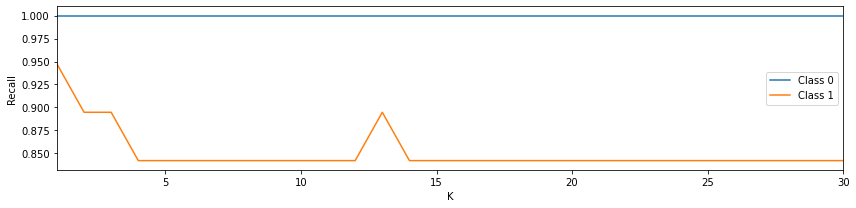

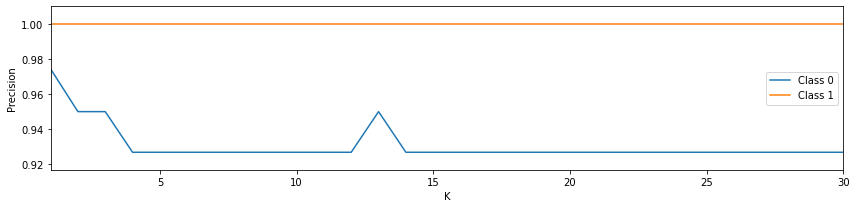

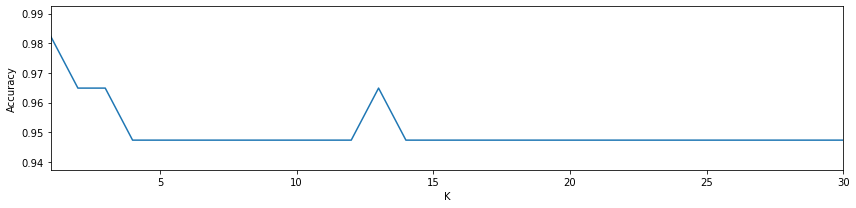

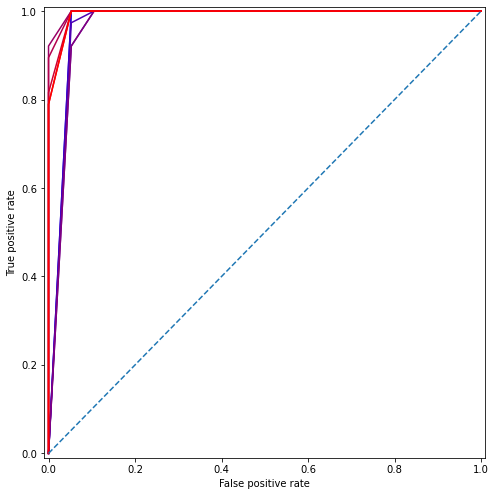

In [12]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
mean = np.mean(np.array(X_train), axis=0)
std = np.std(np.array(X_train), axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

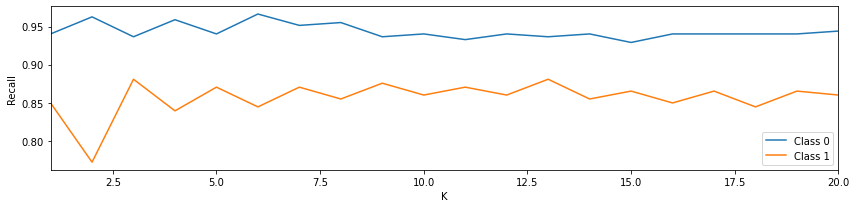

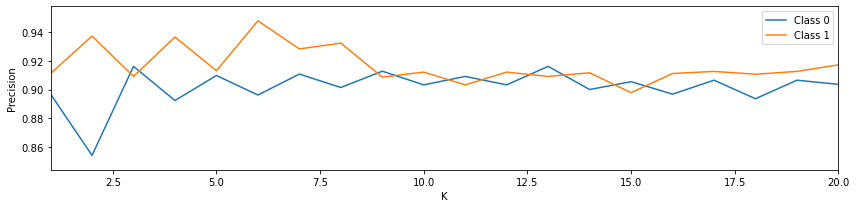

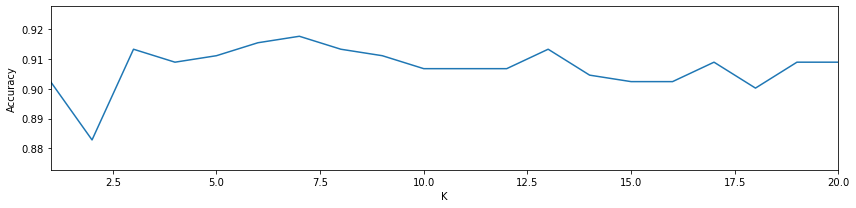

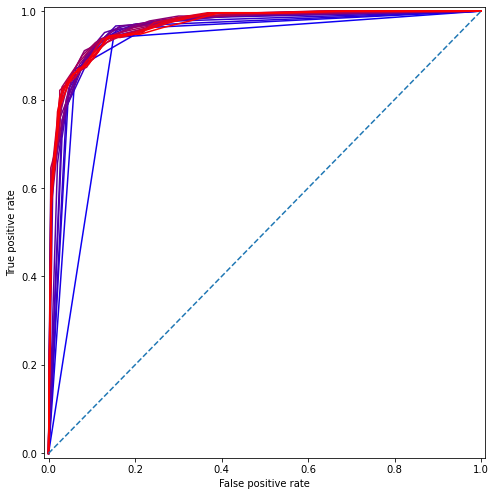

In [13]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
mean = np.mean(np.array(X_train), axis=0)
std = np.std(np.array(X_train), axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)
